In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load data
df = pd.read_csv("delivery_dataset.csv")

print("Shape:", df.shape)
df.head()

Shape: (43739, 16)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [3]:
df.info() ## check data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


In [4]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64


In [5]:
### before after 

In [6]:
# Fill missing values
df['Agent_Rating'] = df['Agent_Rating'].fillna(df['Agent_Rating'].mean())
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
# Show remaining null values per column
print("Missing values after correction:\n")
print(df.isnull().sum())


Missing values after correction:

Order_ID           0
Agent_Age          0
Agent_Rating       0
Store_Latitude     0
Store_Longitude    0
Drop_Latitude      0
Drop_Longitude     0
Order_Date         0
Order_Time         0
Pickup_Time        0
Weather            0
Traffic            0
Vehicle            0
Area               0
Delivery_Time      0
Category           0
dtype: int64


In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    
    return c * r

In [8]:
# 2. Function to calculate time difference in minutes
def calculate_time_difference(order_time, pickup_time):
    """Calculate minutes between order_time and pickup_time"""
    # Check for NaN or missing values
    if pd.isna(order_time) or pd.isna(pickup_time):
        return np.nan
        
    try:
        fmt = '%H:%M:%S'
        order_time_obj = datetime.strptime(str(order_time), fmt)
        pickup_time_obj = datetime.strptime(str(pickup_time), fmt)
        
        # Handle cases where pickup is on the next day
        diff_minutes = (pickup_time_obj - order_time_obj).total_seconds() / 60
        
        # If negative, assume pickup is on the next day (rare case)
        if diff_minutes < -720:  # More than 12 hours negative
            diff_minutes += 1440  # Add 24 hours in minutes
        
        return diff_minutes
    except ValueError:
        # Handle any formatting errors
        print(f"Error parsing time: {order_time} or {pickup_time}")
        return np.nan

In [9]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

In [10]:
# 4. Create feature 1: Distance between store and drop-off in km
df['Distance_KM'] = df.apply(
    lambda row: haversine_distance(
        row['Store_Latitude'], 
        row['Store_Longitude'], 
        row['Drop_Latitude'], 
        row['Drop_Longitude']
    ), 
    axis=1)

In [11]:
df['Pickup_Delay_Minutes'] = df.apply(lambda row: calculate_time_difference(row['Order_Time'], row['Pickup_Time']),axis=1)

Error parsing time: NaN or 17:20:00
Error parsing time: NaN or 20:30:00
Error parsing time: NaN or 22:10:00
Error parsing time: NaN or 12:30:00
Error parsing time: NaN or 23:20:00
Error parsing time: NaN or 18:50:00
Error parsing time: NaN or 20:55:00
Error parsing time: NaN or 18:05:00
Error parsing time: NaN or 20:50:00
Error parsing time: NaN or 22:10:00
Error parsing time: NaN or 10:00:00
Error parsing time: NaN or 08:35:00
Error parsing time: NaN or 23:25:00
Error parsing time: NaN or 18:25:00
Error parsing time: NaN or 17:55:00
Error parsing time: NaN or 20:10:00
Error parsing time: NaN or 08:50:00
Error parsing time: NaN or 20:55:00
Error parsing time: NaN or 11:30:00
Error parsing time: NaN or 21:15:00
Error parsing time: NaN or 11:25:00
Error parsing time: NaN or 20:50:00
Error parsing time: NaN or 20:40:00
Error parsing time: NaN or 21:25:00
Error parsing time: NaN or 09:35:00
Error parsing time: NaN or 22:50:00
Error parsing time: NaN or 23:55:00
Error parsing time: NaN or 1

In [12]:
# 6. Create feature 4: Day of the week
# Convert Order_Date to datetime to extract day of week
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Day_Of_Week'] = df['Order_Date'].dt.day_name()

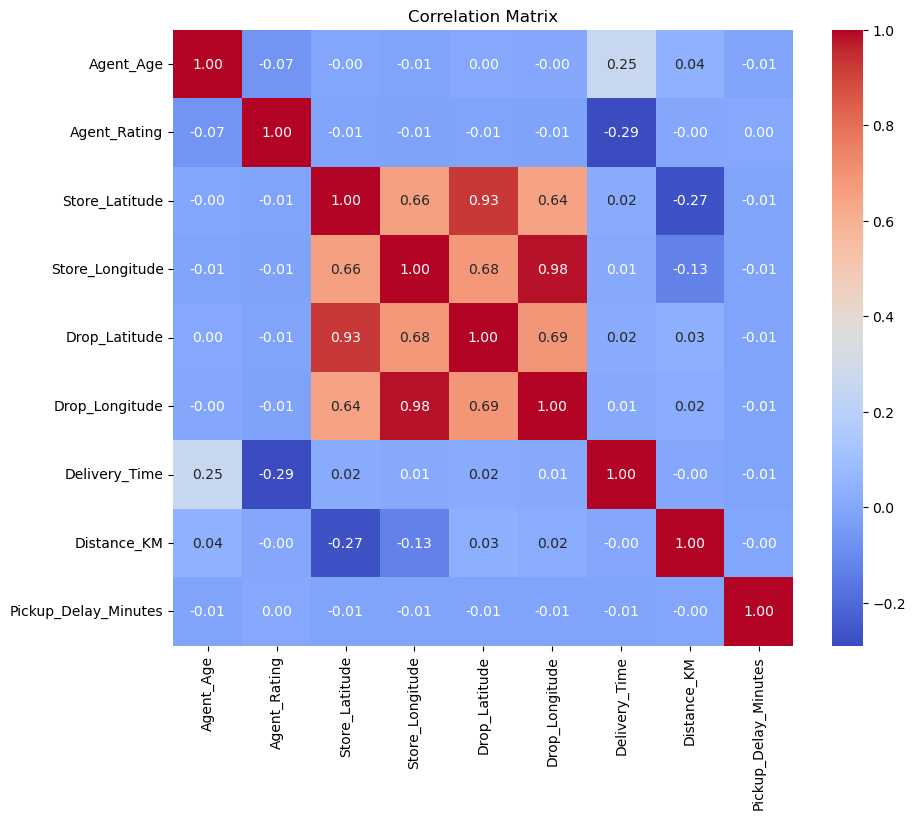

In [13]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S').dt.time
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S').dt.time

# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [14]:
df.shape

(43739, 19)

In [15]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_KM,Pickup_Delay_Minutes,Day_Of_Week
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,15.0,Saturday
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,5.0,Friday
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,15.0,Saturday
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,10.0,Tuesday
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,15.0,Saturday


In [16]:
df.to_csv("delivery_dataset_powerbi.csv", index = False)